<h1> Digital House - Desafio Final - Grupo 5

<p style="font-size:30px;"><img src="https://images.assets-landingi.com/nwecv1cm63viKlsD/Logos_Digital_House_blanco.png" align="center" width="500" height="150"></img></p>

<font color='violet'>
    
# INDICE:
<h7>
<font color='violet'>

1. [LIBRERÍAS](#librerias)

2. [MODELING](#modelos)

    2.1. [Seteo del Dataset](#seteodataset)

    2.2. [Construcción Train Test Split](#construcciontraintest)

    2.3. [Regresión logística](#regresionlogistica)

    2.4. [Árboles de decisión](#arboles)

    2.5. [Bagging & Random Forest](#randomforest)

    2.6. [K-Nearest Neighbors (KNN)](#knn)

    2.7. [Comparación de los resultados obtenidos](#resultados)

    2.8. [Modelo de ensamble](#ensamble)  

3. [PIPELINE](#pipeline)
    
4. [PICKLE-FLASK](#pickle)

</h7>

<h2> 1. Librerías  <div id='librerias'>

In [1]:
#Importamos las librerias que vamos a usar.

import pandas as pd
import numpy as np
import geopandas as gpd
import re

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from pylab import *
import seaborn as sns
import plotly.graph_objects as go


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn import tree

import statsmodels.api as sm
import pydotplus

from IPython.display import Image
from scipy.stats import mode


<hr>
    <font color='violet'>
    <h1> 2. MODELING </h1> <div id='construcciondataset'>
<font color='white'>
</div>
<hr>

<h2> 2.1. Dataset <div id='dataset'>
    

<h7>importamos nuestro dataset.

In [2]:
#Importamos el DF de US Accidents (2016 - 2021) ya limpiado.

df = pd.read_csv('../US_STATE_CO_Accidents limpieza y analisis.csv')

display(df.head(3))
print('Este Dataset tiene', df.shape[0], 'filas y',df.shape[1],'columnas.')

Severity           Start_Time             End_Time  Start_Lat   Start_Lng  \
0         2  2016-11-30 15:27:44  2016-11-30 21:27:44  38.936713 -104.797781   
1         2  2016-11-30 17:02:58  2016-11-30 23:02:58  40.309220 -104.980870   
2         2  2016-12-01 13:19:57  2016-12-01 19:19:57  38.831476 -104.840994   

     End_Lat     End_Lng  Distance(mi)                    Description  \
0  38.938301 -104.798323         0.114      At Shrider Rd - Accident.   
1  40.303590 -104.980910         0.389  At CO-56/Exit 250 - Accident.   
2  38.831469 -104.840974         0.001         At 14th St - Accident.   

            Street  ... Nov Oct Sep Mon Sat Sun Thu  Tue  Wed  \
0   N Academy Blvd  ...   1   0   0   0   0   0   0    0    1   
1          US-87 S  ...   1   0   0   0   0   0   0    0    1   
2  W US Highway 24  ...   0   0   0   0   0   0   1    0    0   

                        geometry  
0  POINT (-104.797781 38.936713)  
1    POINT (-104.98087 40.30922)  
2  POINT (-104.840994 38.831476)  

[3 rows x 64 columns]

Este Dataset tiene 18552 filas y 64 columnas.


<hr>
    <font color='violet'>
    <h1> 2. MODELING </h1> <div id='modelos'>
<font color='white'>
</div>
<hr>

<h7>En esta sección vamos a implementar modelos de machine learning para intentar predecir la severidad de los accidentes. Para ello, vamos a ejecutar modelos de regresión logística, KNN y árboles de decisión.

<h2> 2.1. Seteo del Dataset<div id='seteodataset'>

<h7> Seteamos nuestros Dataset para poder implementar de manera óptima los distintos modelos.
Primero empezamos analizando los tipo de columas para descartar aquellas que no sirvan para realizar el modelo.

In [3]:
#Creamos una lista para identificar todos los tipos de datos de las columnas.
tipos_columnas = df.dtypes.value_counts()
print('Cantidad de columnas por tipo de dato:\n',tipos_columnas)

Cantidad de columnas por tipo de dato:
 int64      24
object     17
float64    12
bool       11
dtype: int64


<h7>Listamos las columnas que podríamos usar para los modelos (todas menos los que son de tipo object, timestamp ni geometry).

In [4]:
#Creamos una lista para identificar las columas validas y luego la imprimimos.
columnas_validas = []
tipos_de_datos_invalidos=["object", "datetime64[ns]", "geometry"]
for i in df.columns:
    b = str(df[i].dtype)
    if b not in tipos_de_datos_invalidos:
        columnas_validas.append(i)

print('Cantidad de columnas validas:',len(columnas_validas))
print('\nListado de columnas validas:\n',columnas_validas)

Cantidad de columnas validas: 47

Listado de columnas validas:
 ['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset_Night', 'Highway', 'Street_&_Ave', 'Year', 'Day', 'Hour', 'Time_Duration(min)', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']


<h7>Creamos un nuevo Dataframe con las columnas.

In [5]:
df_features = df[columnas_validas]
df_features.head(3)

Severity  Start_Lat   Start_Lng    End_Lat     End_Lng  Distance(mi)  \
0         2  38.936713 -104.797781  38.938301 -104.798323         0.114   
1         2  40.309220 -104.980870  40.303590 -104.980910         0.389   
2         2  38.831476 -104.840994  38.831469 -104.840974         0.001   

   Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  ...  May  Nov  \
0            37.8         16.0         29.95            10.0  ...    0    1   
1            28.4         31.0         29.88            10.0  ...    0    1   
2            35.4         26.0         30.02            10.0  ...    0    0   

   Oct  Sep  Mon  Sat  Sun  Thu  Tue  Wed  
0    0    0    0    0    0    0    0    1  
1    0    0    0    0    0    0    0    1  
2    0    0    0    0    0    1    0    0  

[3 rows x 47 columns]

[Text(0.5, 0, 'Severity'),
 Text(1.5, 0, 'Start_Lat'),
 Text(2.5, 0, 'Start_Lng'),
 Text(3.5, 0, 'End_Lat'),
 Text(4.5, 0, 'End_Lng'),
 Text(5.5, 0, 'Distance(mi)'),
 Text(6.5, 0, 'Temperature(F)'),
 Text(7.5, 0, 'Humidity(%)'),
 Text(8.5, 0, 'Pressure(in)'),
 Text(9.5, 0, 'Visibility(mi)'),
 Text(10.5, 0, 'Wind_Speed(mph)'),
 Text(11.5, 0, 'Precipitation(in)'),
 Text(12.5, 0, 'Amenity'),
 Text(13.5, 0, 'Bump'),
 Text(14.5, 0, 'Crossing'),
 Text(15.5, 0, 'Give_Way'),
 Text(16.5, 0, 'Junction'),
 Text(17.5, 0, 'No_Exit'),
 Text(18.5, 0, 'Railway'),
 Text(19.5, 0, 'Station'),
 Text(20.5, 0, 'Stop'),
 Text(21.5, 0, 'Traffic_Calming'),
 Text(22.5, 0, 'Traffic_Signal'),
 Text(23.5, 0, 'Sunrise_Sunset_Night'),
 Text(24.5, 0, 'Highway'),
 Text(25.5, 0, 'Street_&_Ave'),
 Text(26.5, 0, 'Year'),
 Text(27.5, 0, 'Day'),
 Text(28.5, 0, 'Hour'),
 Text(29.5, 0, 'Time_Duration(min)'),
 Text(30.5, 0, 'Aug'),
 Text(31.5, 0, 'Dec'),
 Text(32.5, 0, 'Feb'),
 Text(33.5, 0, 'Jan'),
 Text(34.5, 0, 'Jul'),
 Te

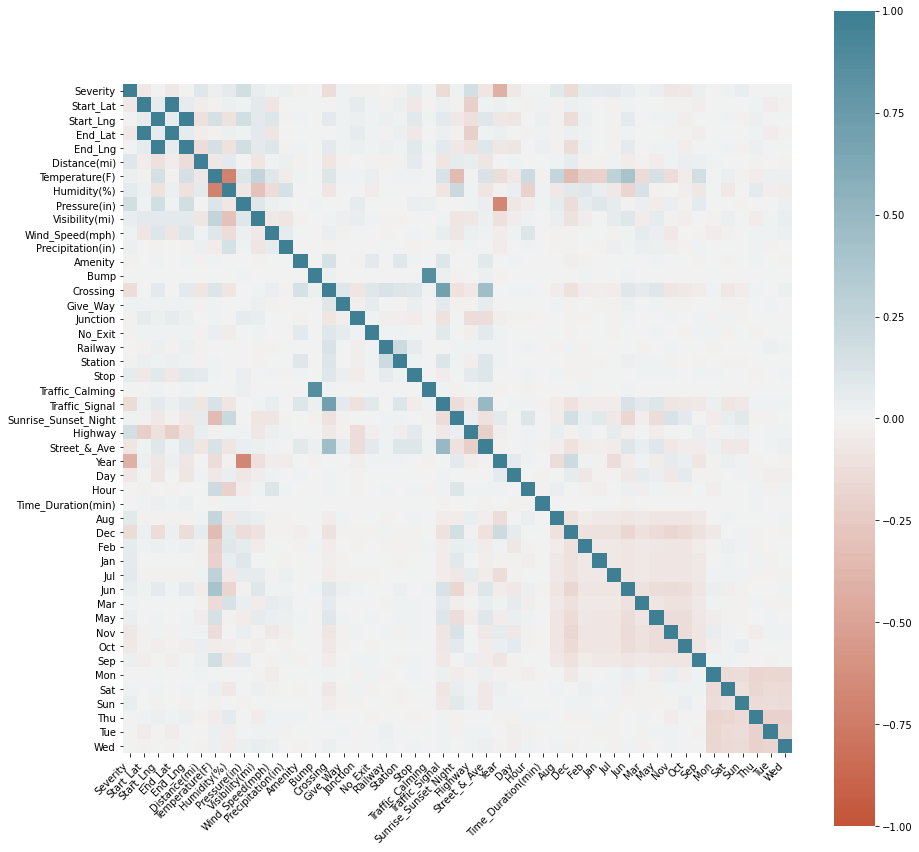

In [6]:
corr2 = df_features.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

<h2> 2.2. Construcción Train Test Split<div id='construcciontraintest'>

<h7>Creamos la matriz de features y el vector de variable target "Y" que será la columna "Severity".

In [7]:
# Seteamos nuestro target a predecir.
target='Severity'

#Creamos la matriz de features "X" y dropeamos la columna de nuestro target.
X = df_features.drop(target,axis=1)

#Creamos la variable "y" que es la serie del target.
y = df_features[target]

#Visualizamos los objetos creamos y chequeamos que no haya errores.
print('Tamaño de "X":', X.shape)
print('Tamaño de "y":', y.shape)
if X.shape[0] != y.shape[0]:
  print("Las filas de X e y no coinciden, chequear dataset")

Tamaño de "X": (18552, 46)
Tamaño de "y": (18552,)


<h7>Visualizamos cual seria nuestra hipotesis nula.

In [8]:
round(y.value_counts(normalize=True), 2)

2    0.49
3    0.35
4    0.15
1    0.02
Name: Severity, dtype: float64

<h7>Capturamos nuestra hipotesis nula

In [9]:
lista_target = y.value_counts(normalize=True).tolist()
hipotesis_nula=lista_target[0]
print('Nuestra hipótesis nula es:',hipotesis_nula)

Nuestra hipótesis nula es: 0.4863626563173782


<h7> La hipotesis nula seria el valor con mayor porcentaje de la muestra, en este caso es el grado de severidad 2 (siendo 1 el más leve y 4 el mas grave).

Procedemos a setear nuestros datos de entrenamiento y test.

In [10]:
# Split the data set into training and testing data sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,stratify=y)

In [11]:
# Verificamos que coincidan las proporciones del target.
y_train.mean(), y_test.mean()

(2.6133528415216385, 2.6130075458138697)

In [12]:
#comprobamos que ambos conjuntos hayan quedado balanceados de acuerdo al valor de la variable target.
print('y_train:\n', y_train.value_counts(normalize=True).round(2))
print('\ny_test:\n', y_test.value_counts(normalize=True).round(2))

y_train:
 2    0.49
3    0.35
4    0.15
1    0.02
Name: Severity, dtype: float64

y_test:
 2    0.49
3    0.35
4    0.15
1    0.02
Name: Severity, dtype: float64


<h7> Estandarizamaos los conjuntos de entrenamiento y testeo.

In [13]:
scaler = StandardScaler()
X_train_scl= scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

#Comprobamos y comparamos el tamaño.
print('Tamaño de "X_train_scl":',(X_train_scl).shape)
print('Tamaño de "X_train":',(X_train).shape)

Tamaño de "X_train_scl": (12986, 46)
Tamaño de "X_train": (12986, 46)


<h7>Creamos 2 listados para los modelos utilizados y sus accuracy. 

In [14]:
#Listado de los modelos.
listado_modelos=['Logistic Regression', 'Decision Trees', 'Bagging', 'Random Forest', 'KNN',  'KNN SCL']

#Listado de los accuracy.
accuracy_modelos=[]

<h2> 2.3. Regresión logística <div id='regresionlogistica'>

<h7> Como x_train_scl y x_test_scl ya esta estandarizados, procedemos a instanciar el modelo.

In [15]:
#Ajuste del modelo.
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_scl, y_train)

#averiguamos "fit 1" para el modelo de ensamble.
fit_1= lr.fit(X_train_scl, y_train)

#Hacemos predicciones con el modelo entrenado.
y_test_pred = lr.predict(X_test_scl)

# Obtenemos el accuracy.
accuracy_lr = accuracy_score(y_test, y_test_pred)
accuracy_modelos.append(accuracy_lr)

print("Regresión logística accuracy score: {:.3f}.".format(accuracy_lr))

Regresión logística accuracy score: 0.759.


Text(0.5, 24.0, 'Severidad Predicha')

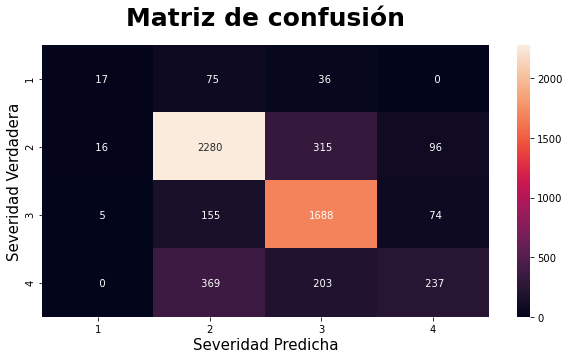

In [16]:
#Realizamos una matríz de confusión.
plt.figure(figsize=(10,5))
plt.title('Matriz de confusión', size=25, color='black',weight = 'bold',y=1.05)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='4d',xticklabels=[1,2,3,4],yticklabels=[1,2,3,4])
plt.ylabel('Severidad Verdadera', size=15, labelpad=3)
plt.xlabel('Severidad Predicha', size=15, labelpad=3)

In [17]:
#Optimizacion del modelo
lr.predict_proba(X_train_scl).shape

lr.predict_proba(X_train_scl)

#Cada una de las 4 clases tiene sus propios coeficientes e interceptos:
lr.coef_    #.coef_ tendrá forma (N_clases, N_features)

lr.intercept_   #.intercept_ tendrá forma (N_clases,)

lr.classes_

array([1, 2, 3, 4], dtype=int64)

In [18]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.45      0.13      0.20       128
           2       0.79      0.84      0.82      2707
           3       0.75      0.88      0.81      1922
           4       0.58      0.29      0.39       809

    accuracy                           0.76      5566
   macro avg       0.64      0.54      0.56      5566
weighted avg       0.74      0.76      0.74      5566



In [19]:
#Vamos a testear hiperparámetros, para ello generamos un diccionario incluyendo los hiperparámetros del modelo que queremos probar:

In [20]:
lreg = LogisticRegression()

In [21]:
params = [
    {'C': [1, 10, 100, 1000],
     'penalty': ['l1', 'l2',],
     'solver': ['saga']}]

In [22]:
from sklearn.model_selection import StratifiedKFold
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [23]:
gs = GridSearchCV(lreg, param_grid=params, scoring='accuracy', cv=folds, n_jobs=-1)
print (gs)
gs.fit(X_train_scl, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                          'solver': ['saga']}],
             scoring='accuracy')


C:\Users\User\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                          'solver': ['saga']}],
             scoring='accuracy')

In [24]:
#Mejor score y parametros durante el entrenamiento.
print('\nMejor score durante el entrenamiento: {:.3f}'.format(gs.best_score_))
print('\nMejores parametros del modelo que mejor performó:\n', gs.best_params_) 

#Visualizamos y guardamos el mejor estimador.
cv_lr = gs.best_estimator_
print('\nMejor estimador:\n', cv_lr)


Mejor score durante el entrenamiento: 0.753

Mejores parametros del modelo que mejor performó:
 {'C': 1, 'penalty': 'l1', 'solver': 'saga'}

Mejor estimador:
 LogisticRegression(C=1, penalty='l1', solver='saga')


In [25]:
pd.DataFrame(gs.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       6.736119      0.156646         0.003125        0.006249       1   
1       5.363321      0.205205         0.000000        0.000000       1   
2       7.867831      0.321919         0.000000        0.000000      10   
3       5.817191      0.138608         0.000500        0.000670      10   
4       8.070370      0.126895         0.000500        0.000806     100   
5       5.712743      0.138861         0.001563        0.004688     100   
6       8.196039      0.193427         0.001563        0.004688    1000   
7       5.693566      0.171657         0.000000        0.000000    1000   

  param_penalty param_solver                                          params  \
0            l1         saga     {'C': 1, 'penalty': 'l1', 'solver': 'saga'}   
1            l2         saga     {'C': 1, 'penalty': 'l2', 'solver': 'saga'}   
2            l1         saga    {'C': 10, 'penalty': 'l1', 'solver': 'saga'}   
3            l2         saga    {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   
4            l1         saga   {'C': 100, 'penalty': 'l1', 'solver': 'saga'}   
5            l2         saga   {'C': 100, 'penalty': 'l2', 'solver': 'saga'}   
6            l1         saga  {'C': 1000, 'penalty': 'l1', 'solver': 'saga'}   
7            l2         saga  {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}   

   split0_test_score  split1_test_score  ...  split3_test_score  \
0            0.73903           0.763664  ...           0.752887   
1            0.73749           0.762125  ...           0.752887   
2            0.73749           0.762895  ...           0.752887   
3            0.73749           0.762895  ...           0.752887   
4            0.73749           0.762895  ...           0.752887   
5            0.73749           0.762895  ...           0.752887   
6            0.73749           0.762895  ...           0.752887   
7            0.73749           0.762895  ...           0.752887   

   split4_test_score  split5_test_score  split6_test_score  split7_test_score  \
0           0.747498           0.759815            0.74037           0.762712   
1           0.747498           0.760585            0.74037           0.761941   
2           0.748268           0.759815            0.74037           0.761941   
3           0.748268           0.759815            0.74037           0.761941   
4           0.748268           0.759815            0.74037           0.762712   
5           0.748268           0.759815            0.74037           0.761941   
6           0.748268           0.759815            0.74037           0.762712   
7           0.748268           0.759815            0.74037           0.762712   

   split8_test_score  split9_test_score  mean_test_score  std_test_score  \
0           0.739599           0.764253         0.752502        0.009737   
1           0.738829           0.764253         0.752117        0.009877   
2           0.738829           0.764253         0.752194        0.009862   
3           0.738829           0.764253         0.752194        0.009862   
4           0.738829           0.764253         0.752271        0.009940   
5           0.738829           0.764253         0.752194        0.009862   
6           0.738829           0.764253         0.752271        0.009940   
7           0.738829           0.764253         0.752271        0.009940   

   rank_test_score  
0                1  
1                8  
2                5  
3                5  
4                2  
5                5  
6                2  
7                2  

[8 rows x 21 columns]

In [26]:
y_preds_log = gs.predict(X_test_scl)

In [27]:
print (classification_report(y_test, y_preds_log))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       128
           2       0.79      0.85      0.82      2707
           3       0.75      0.88      0.81      1922
           4       0.58      0.29      0.38       809

    accuracy                           0.76      5566
   macro avg       0.53      0.50      0.50      5566
weighted avg       0.73      0.76      0.73      5566



In [28]:
confusion_matrix(y_test, y_preds_log)

array([[   0,   91,   37,    0],
       [   2, 2296,  315,   94],
       [   0,  158, 1688,   76],
       [   0,  372,  204,  233]], dtype=int64)

In [29]:
# Observamos el resultado de correr el modelo con esos hiperparámetros sobre los datos de testeo y obtenemos el accuracy.

In [30]:
accuracy_lreg = accuracy_score(y_test, cv_lr.predict(X_test_scl))
print('Accuracy para el modelos de Arboles: {:.3f}'.format(accuracy_lreg))

Accuracy para el modelos de Arboles: 0.758


In [31]:
#Guardamos nuestro accuracy en la lista. 
#accuracy_modelos.append(accuracy_lreg)

<h2> 2.4. Árboles de decisión <div id='arboles'>

<h7>Instanciamos el modelo con los hiperparámetros por default.

In [32]:
clftree = tree.DecisionTreeClassifier()

#Fiteamos el modelo
clftree.fit(X_train_scl, y_train)

#Ejecutamos las predicciones con y_train & y_test
y_train_pred = clftree.predict(X_train_scl)
y_test_pred = clftree.predict(X_test_scl)

<h7>Observamos el accuracy y la matriz de confusión ,solamente, para el vector de **entrenamiento**.

El accuracy de los datos de entrenamiento arroja un resultado de 99.31%


Text(0.5, 24.0, 'Severidad Predicha')

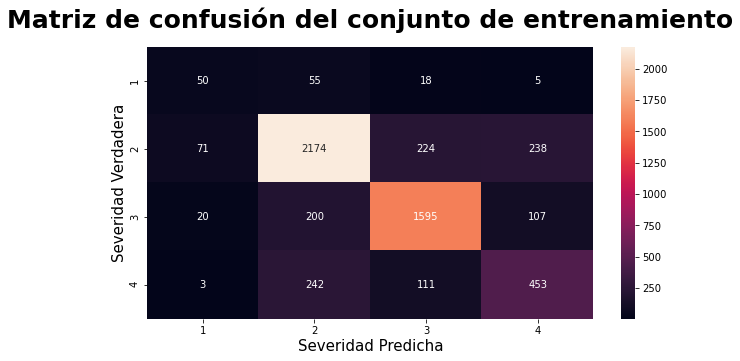

In [33]:
print(f"El accuracy de los datos de entrenamiento arroja un resultado de {accuracy_score(y_train, y_train_pred).round(4)*100}%")

#Realizamos una matríz de confusión.
plt.figure(figsize=(10,5))
plt.title('Matriz de confusión del conjunto de entrenamiento', size=25, color='black',weight = 'bold',y=1.05)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,fmt="g",xticklabels=[1,2,3,4],yticklabels=[1,2,3,4])
plt.ylabel('Severidad Verdadera', size=15, labelpad=3)
plt.xlabel('Severidad Predicha', size=15, labelpad=3)

<h7>Ahora, pasamos a observamos el accuracy y la matriz de confusión ,solamente, para el vector de **testeo**.

En comparación a los datos de entrenamiento, el accuracy del modelo con los datos de test arroja un resultado mucho mas bajo de: 76.75%


Text(0.5, 24.0, 'Severidad Predicha')

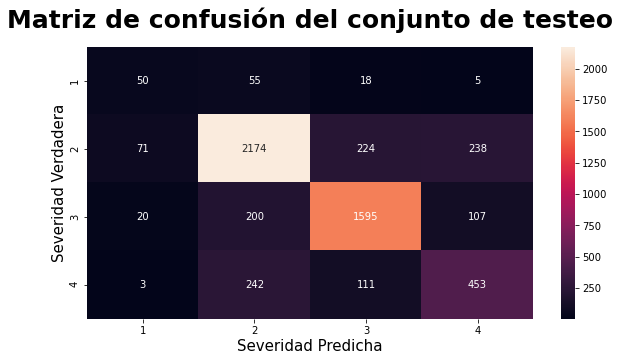

In [34]:
print(f"En comparación a los datos de entrenamiento, el accuracy del modelo con los datos de test arroja un resultado mucho mas bajo de: {accuracy_score(y_test, y_test_pred).round(4)*100}%")

#Realizamos una matríz de confusión del conjunto de testeo.
plt.figure(figsize=(10,5))
plt.title('Matriz de confusión del conjunto de testeo', size=25, color='black',weight = 'bold',y=1.05)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,fmt="g",xticklabels=[1,2,3,4],yticklabels=[1,2,3,4])
plt.ylabel('Severidad Verdadera', size=15, labelpad=3)
plt.xlabel('Severidad Predicha', size=15, labelpad=3)

<h7>A continuación, creamos un dataframe con las features y su importancia relativa dentro del modelo y visualizamos los 10 mas importantes.

In [35]:
df_atributos = pd.DataFrame({'atributo':X.columns, 'importancia':clftree.feature_importances_}).sort_values('importancia', ascending = False)
df_atributos.head(10)

atributo  importancia
25                Year     0.282506
28  Time_Duration(min)     0.147058
4         Distance(mi)     0.100615
7         Pressure(in)     0.039739
1            Start_Lng     0.039105
5       Temperature(F)     0.038841
27                Hour     0.038175
3              End_Lng     0.033075
6          Humidity(%)     0.030364
21      Traffic_Signal     0.027244

<h7>Generamos la variable dot_data, que guarda el árbol en un archivo de texto que nos servirá para graficar el primer árbol considerando todas las features del vector de features.

In [36]:
dot_data = tree.export_graphviz(clftree, out_file=None,feature_names= X_train.columns, filled = True)

<h7>Observamos que el árbol original es demasiado grande y por ende de poca utilidad.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.292764 to fit



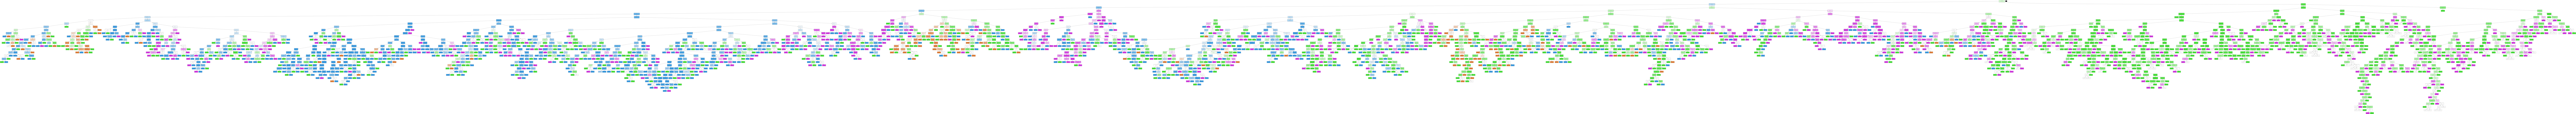

In [37]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

<h7>Vamos a testear **hiperparámetros**, para ello generamos un diccionario incluyendo los hiperparámetros del modelo que queremos probar:
    <br> Critrerio para medir la pureza del split: Gini o entropía.
    <br> Profundidad Máxima: Probar con el rango de 1 a 14 y sin máximo.
    <br> Número mínimo de muestras requerido para separar un nodo: Probar con el rango de 2 a 4 y sin mínimo.
    <br> Número mínimo de muestras por hoja: Probar con 5, 10, 15, 20 y sin mínimo.

In [38]:
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,None],
                "min_samples_split": [2, 3, 4,None]}

<h7>Paralelamente haremos **CrossValidation** con GridSearch:
<br> Modelo: árbol de decisión (clftree).
<br> Hiperparámetros: los definidos arriba (params_grid).
<br> n_jobs: -1 para que la computadora use todos los procesadores en simultáneo.
<br> score: accuracy.
<br> cv: no especificamos nada, por lo que tonmará la opción por "default" de separar los datos en 5 subconjuntos.

In [39]:
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-1, scoring='accuracy')

<h7>Corremos los modelos y vemos cual es la combinación de hiperparámetros que mejor funciona.

In [40]:
grid_search.fit(X_train_scl, y_train)

#Mejor score y parametros durante el entrenamiento.
print('\nMejor score durante el entrenamiento: {:.3f}'.format(grid_search.best_score_))
print('\nMejores parametros del modelo que mejor performó:\n', grid_search.best_params_) 

#Visualizamos y guardamos el mejor estimador.
cv_clf = grid_search.best_estimator_
print('\nMejor estimador:\n', cv_clf)


Mejor score durante el entrenamiento: 0.787

Mejores parametros del modelo que mejor performó:
 {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 4}

Mejor estimador:
 DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=15,
                       min_samples_split=4)


<h7>Observamos el resultado de correr el modelo con esos hiperparámetros sobre los datos de testeo y obtenemos el accuracy.

In [41]:
accuracy_arboles = accuracy_score(y_test, cv_clf.predict(X_test_scl))
print('Accuracy para el modelos de Arboles: {:.3f}'.format(accuracy_arboles))

Accuracy para el modelos de Arboles: 0.789


In [42]:
#Guardamos nuestro accuracy en la lista. 
accuracy_modelos.append(accuracy_arboles)

<h7>Obtenemos la matriz de confusión.

In [43]:
confusion_matrix(y_test, cv_clf.predict(X_test_scl))

array([[  19,   82,   24,    3],
       [  33, 2317,  265,   92],
       [   3,  114, 1681,  124],
       [   2,  296,  138,  373]], dtype=int64)

<h7>Graficamos el nuevo árbol, que es más chico que el anterior pero aún es demasiado grande y dificil de interpretar.

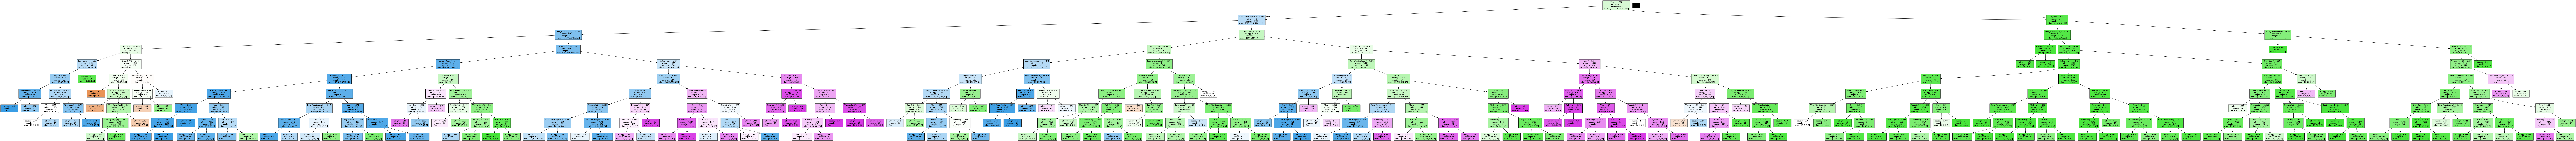

In [44]:
dot_data = tree.export_graphviz(cv_clf, out_file=None,feature_names= X_train.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

<h7>Generamos un nuevo dataframe para ver la importancia relativa de las features en el modelo y visualizamos los 10 mas importantes.

In [45]:
df_atributos_2 = pd.DataFrame({'atributo':X.columns, 'importancia':cv_clf.feature_importances_}).sort_values('importancia', ascending = False)
df_atributos_2.head(10)

atributo  importancia
25                Year     0.428725
28  Time_Duration(min)     0.212211
4         Distance(mi)     0.140606
24        Street_&_Ave     0.047197
23             Highway     0.033701
21      Traffic_Signal     0.024573
7         Pressure(in)     0.016061
27                Hour     0.014232
5       Temperature(F)     0.014137
6          Humidity(%)     0.012111

<h2> 2.5. Bagging & Random Forest <div id='randomforest'>

<h7>Intentaremos robustecer el resultado del modelo a través de las técnicas de Bagging y Randonm Forest. Para ello primero vamos a generar una cantidad de modelos a correr.

In [46]:
lista_de_modelos = []
N_modelos = 10

<h7>Vamos a aplicar Bootstrap a los conjuntos de entrenamiento para generar fluctuabilidad de los datos, y en cada instancia obtendremos un árbol clasificador sin límite de profundidad.

In [47]:
for i in range(N_modelos):
    X_train_boostrap, _, y_train_boostrap, _ = train_test_split(X_train_scl, y_train, test_size=0.3, stratify = y_train)
    clf = tree.DecisionTreeClassifier(max_depth = None)
    clf.fit(X_train_boostrap, y_train_boostrap)
    lista_de_modelos.append(clf)

<h7>Aplicamos los modelos generados al conjunto de testeo y observamos el accuracy de cada instancia.

In [48]:
for idx, modelo in enumerate(lista_de_modelos):
    y_test_pred = modelo.predict(X_test_scl)
    print('Accuracy Modelo ', idx, ' es: ', round(accuracy_score(y_test, y_test_pred),3))

Accuracy Modelo  0  es:  0.751
Accuracy Modelo  1  es:  0.743
Accuracy Modelo  2  es:  0.744
Accuracy Modelo  3  es:  0.745
Accuracy Modelo  4  es:  0.75
Accuracy Modelo  5  es:  0.75
Accuracy Modelo  6  es:  0.749
Accuracy Modelo  7  es:  0.747
Accuracy Modelo  8  es:  0.754
Accuracy Modelo  9  es:  0.755


<h7>Generamos un numpy array de zeros con el mismo tamaño que el conjunto y_test.

In [49]:
probs_test_pred = np.zeros(y_test.size)

<h7>Para cada uno de los modelos generados, calculamos la probabilidad y elegimos las probabilidades que correspondan a la clase positiva y las vamos acumulando en el vector que suma las iteraciones de todas las instancias. Luego dividimos esa suma por la totalidad de iteraciones para hallar la probabilidad promedio.

In [50]:
i=0
for modelo in lista_de_modelos:
    i += 1
    probs_test_pred_modelo = modelo.predict_proba(X_test_scl)
    print('Tamaño del modelo test', i,': ', probs_test_pred_modelo.shape)
    probs_test_pred +=probs_test_pred_modelo[:,1]

Tamaño del modelo test 1 :  (5566, 4)
Tamaño del modelo test 2 :  (5566, 4)
Tamaño del modelo test 3 :  (5566, 4)
Tamaño del modelo test 4 :  (5566, 4)
Tamaño del modelo test 5 :  (5566, 4)
Tamaño del modelo test 6 :  (5566, 4)
Tamaño del modelo test 7 :  (5566, 4)
Tamaño del modelo test 8 :  (5566, 4)
Tamaño del modelo test 9 :  (5566, 4)
Tamaño del modelo test 10 :  (5566, 4)


probs_test_pred = probs_test_pred/N_modelos

<h7>Comparamos los resultados anteriores contra el umbral de 0.5 y aquellos que sean "True" los agregamos al vector "y_test_pred" que usaremos para calcular el accuracy de todos los modelos corridos juntos.

In [51]:
y_test_pred = probs_test_pred > 0.5
y_test_pred = y_test_pred.astype(int)

In [52]:
print('Accuracy Ensamble:', round(accuracy_score(y_test, y_test_pred),4))

Accuracy Ensamble: 0.0217


<h7>Usamos Bagging Classifier para generar modelo un clasificador basado en un árbol de decisión, especificamos que las features no sean tomadas con reposición y que el número máximo de estimadores para armar el árbol "final" sea n=100.

In [53]:
clf = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), bootstrap_features=False, n_estimators= 100, n_jobs = -1)
clf.fit(X_train_scl, y_train)
y_train_pred = clf.predict(X_train_scl)
y_test_pred = clf.predict(X_test_scl)
print('Accuracy Bagging del set de entrenamiento:', round(accuracy_score(y_train, y_train_pred),3))
print('Accuracy Bagging del set de test:',round(accuracy_score(y_test, y_test_pred),3))

Accuracy Bagging del set de entrenamiento: 0.993
Accuracy Bagging del set de test: 0.819


probs_test_pred = probs_test_pred/N_modelos

<h7>Comparamos los resultados anteriores contra el umbral de 0.5 y aquellos que sean "True" los agregamos al vector "y_test_pred" que usaremos para calcular el accuracy de todos los modelos corridos juntos.

In [54]:
y_test_pred = probs_test_pred > 0.5
y_test_pred = y_test_pred.astype(int)

In [55]:
print('Accuracy Ensamble:', round(accuracy_score(y_test, y_test_pred),4))

Accuracy Ensamble: 0.0217


<h7>Usamos Bagging Classifier para generar modelo un clasificador basado en un árbol de decisión, especificamos que las features no sean tomadas con reposición y que el número máximo de estimadores para armar el árbol "final" sea n=100.

In [56]:
clf = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), bootstrap_features=False, n_estimators= 100, n_jobs = -1)
clf.fit(X_train_scl, y_train)
y_train_pred = clf.predict(X_train_scl)
y_test_pred = clf.predict(X_test_scl)
print('Accuracy Bagging del set de entrenamiento:', round(accuracy_score(y_train, y_train_pred),3))
print('Accuracy Bagging del set de test:',round(accuracy_score(y_test, y_test_pred),3))

Accuracy Bagging del set de entrenamiento: 0.993
Accuracy Bagging del set de test: 0.819


<h7>Vemos que con **Bagging** el accuracy sobre el conjunto de entrenamiento aumenta comparado con los modelos anteriores.

In [57]:
#Guardamos nuestro accuracy de Bagging en la lista. 

accuracy_bagging = accuracy_score(y_test, y_test_pred)
accuracy_modelos.append(accuracy_bagging)

<h7>A continuación usaremos **Random Forest** para intentar mejorar los resultados del modelo clasificador.
Para generar modelo un clasificador basado en un árbol de decisión, especificamos que el número máximo de estimadores para armar el árbol "final" sea n=100, limitando la apertura de nodos a la raiz cuadrada de la cantidad de features del dataset y aplicando el _Out Of Bag Score_.

In [58]:
#averiguamos "fit 2" para el modelo de ensamble.
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True)
clf.fit(X_train_scl,y_train)
fit_2= clf.fit(X_train_scl,y_train)

<h7>Aplicamos el modelo sobre los conjuntos de entrenamiento y testeo y observamos el accuracy.

In [59]:
y_train_pred = clf.predict(X_train_scl)
y_test_pred = clf.predict(X_test_scl)
print('Accuracy Random Forest del set de entrenamiento:', round(accuracy_score(y_train, y_train_pred),4))
print('Accuracy Random Forest del set de test:', round(accuracy_score(y_test, y_test_pred),4))

Accuracy Random Forest del set de entrenamiento: 0.993
Accuracy Random Forest del set de test: 0.8277


In [60]:
#Guardamos nuestro accuracy en la lista. 

accuracy_random_forest = accuracy_score(y_test, y_test_pred)
accuracy_modelos.append(accuracy_random_forest)

<h7>Vemos que el _accuracy_ sobre los datos de test mejoran vs la técnica de Bagging.

<h7> Calculamos su `oob_score_` y vemos la importancia relativa de cada feature en el modelo.

In [61]:
print('El "oob score" es de:', round(clf.oob_score_,3))

El "oob score" es de: 0.824


<h7>Graficamos la curva de validación/complejidad para el modelo Random Forest en función del número de estimadores.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 [Text(0, 0, 'Time_Duration(min)'),
  Text(1, 0, 'Year'),
  Text(2, 0, 'Distance(mi)'),
  Text(3, 0, 'End_Lng'),
  Text(4, 0, 'Start_Lng'),
  Text(5, 0, 'Pressure(in)'),
  Text(6, 0, 'Start_Lat'),
  Text(7, 0, 'End_Lat'),
  Text(8, 0, 'Temperature(F)'),
  Text(9, 0, 'Humidity(%)'),
  Text(10, 0, 'Hour'),
  Text(11, 0, 'Day'),
  Text(12, 0, 'Wind_Speed(mph)'),
  Text(13, 0, 'Street_&_Ave'),
  Text(14, 0, 'Visibility(mi)'),
  Text(15, 0, 'Traffic_Signal'),
  Text(16, 0, 'Dec'),
  Text(17, 0, 'Highway'),
  Text(18, 0, 'Crossing'),
  Text(19, 0, 'Sunrise_Sunset_Night'),
  Text(20, 0, 'Nov'),
  Text(21, 0, 'Wed'),
  Text(22, 0, 'Thu'),
  Text(23, 0, 'May'),
  Text(24, 0, 'Jun'),
  Text(25, 0, 'Junction'),
  Text(26, 0, 'Mon'),
  Text(27, 0, 'Oct'),
  Text(28, 0, 'Tue'),
  Text(29, 0, 

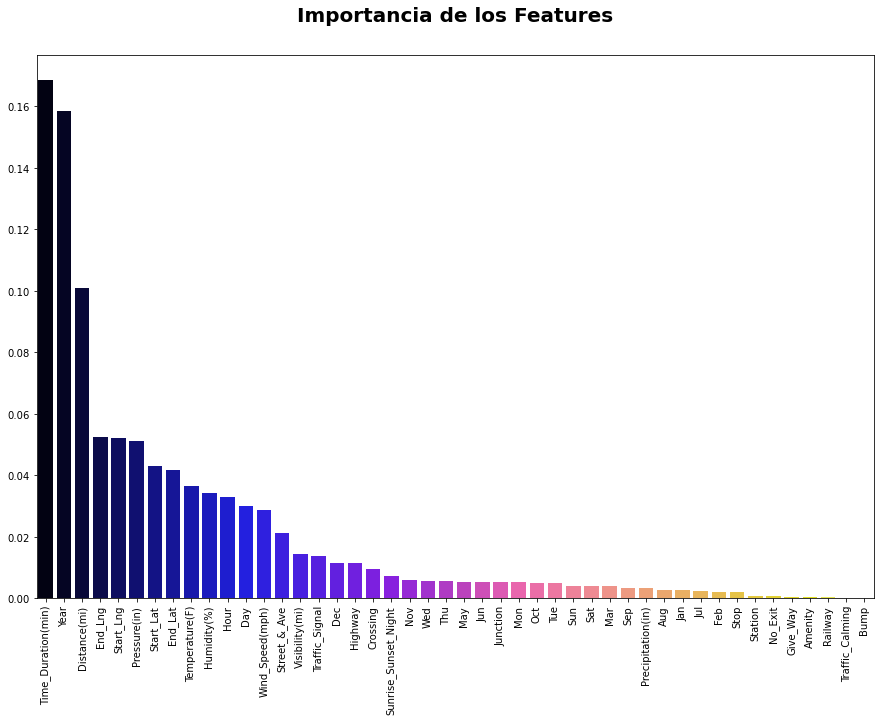

In [62]:
importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

#Código del gráfico.
plt.figure(figsize = (15,10))
plt.title('Importancia de los Features', size=20, color='black',weight = 'bold', y=1.05);
sns.barplot(x = columns[indices], y = importances[indices], palette='gnuplot2')
plt.xticks(rotation='vertical')

<h2> 2.6. K-Nearest Neighbors (KNN) <div id='knn'>

<h7> Con el metodo de algoritmo supervisado de KNN, vamos a querer predecir la "severity" de los accidentes.

<h7> Realizamos una función para determinar el mejor resultado de KNN:

In [63]:
def scores_knn(X, y, start,stop,step,n_splits):
    
    #Creamos uns lista vacia para ir alimentándola en cada iteración.
    scores_para_df = []
    
    for i in range(start,stop,step):
        
        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
        kf = KFold(n_splits, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)
    
    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)
    
    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    
    #Prediciendo sobre test.
    
    # Asignamos el valor del k óptimo a una variable
    best_k = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(),'n_neighbours'].values[0]
    
    # Elegimos el modelo óptimo que nos había indicado cross validation
    model = KNeighborsClassifier(n_neighbors=best_k)

    # Lo ajustamos sobre datos de entrenamiento
    model.fit(X_train, y_train)

    # Evaluamos qué accuracy obtenemos en train
    accuracy_score(y_train, model.predict(X_train))

    # Lo utilizamos para predecir en test
    y_pred = model.predict(X_test)

    # Computamos el accuracy score en test
    accuracy_knn = accuracy_score(y_test, y_pred)

    # Retornamos el DF y el accuracy
    return df_scores, accuracy_knn, best_k

K-Nearest Neighbors(K-NN) accuracy score: 0.713
El mejor K es: 9


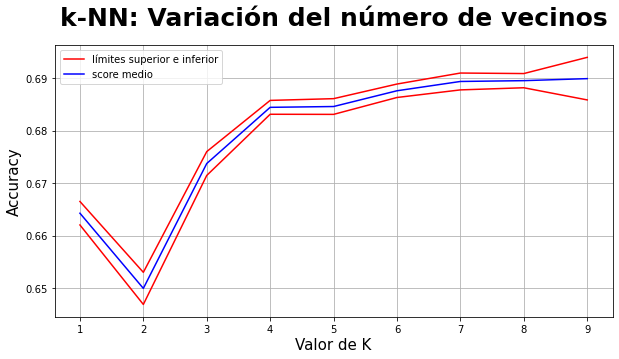

In [64]:
# Probamos de 1 a 9 vecinos y 5 n_splits.
df_scores, accuracy_knn, best_k = scores_knn(X_train, y_train, 1, 10, 1, 3)

print('K-Nearest Neighbors(K-NN) accuracy score: {:.3f}'.format(accuracy_knn))
print('El mejor K es:', best_k)

#visualizamos los resultrados obtenidos. 
plt.figure(figsize=(10,5))
plt.title('k-NN: Variación del número de vecinos', size=25, color='black',weight = 'bold',y=1.05)
plt.plot(df_scores['n_neighbours'], df_scores['limite_inferior'], color='r')
plt.plot(df_scores['n_neighbours'], df_scores['score_medio'], color='b')
plt.plot(df_scores['n_neighbours'], df_scores['limite_superior'], color='r')
plt.legend(labels = ['límites superior e inferior','score medio'],prop={'size': 10}, loc='best', title_fontsize=18, markerscale = 2.0)
plt.xlabel('Valor de K', size=15, labelpad=3)
plt.ylabel('Accuracy', size=15, labelpad=3)
plt.grid()

<h7> Realizamos una estandarizacón del modelo para analizar si hay diferencia de resultados con lo obtenido anteriormente.  

K-Nearest Neighbors(K-NN) accuracy score estandarizado: 0.690

El mejor K es: 1


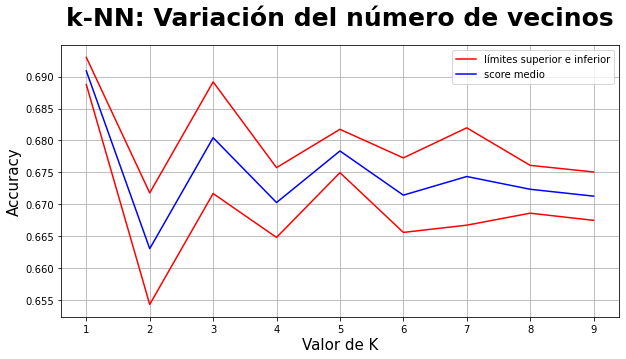

In [65]:
# Probamos de 1 a 9 vecinos y 5 n_splits.
df_scores_std, accuracy_knn_std, best_k_std = scores_knn(X_train_scl, y_train, 1, 10, 1, 3)

print('K-Nearest Neighbors(K-NN) accuracy score estandarizado: {:.3f}'.format(accuracy_knn_std))
print('\nEl mejor K es:', best_k_std)

#visualizamos los resultrados obtenidos. 
plt.figure(figsize=(10,5))
plt.title('k-NN: Variación del número de vecinos', size=25, color='black',weight = 'bold',y=1.05)
plt.plot(df_scores_std['n_neighbours'], df_scores_std['limite_inferior'], color='r')
plt.plot(df_scores_std['n_neighbours'], df_scores_std['score_medio'], color='b')
plt.plot(df_scores_std['n_neighbours'], df_scores_std['limite_superior'], color='r')
plt.legend(labels = ['límites superior e inferior','score medio'],prop={'size': 10}, loc='best', title_fontsize=18, markerscale = 2.0)
plt.xlabel('Valor de K', size=15, labelpad=3)
plt.ylabel('Accuracy', size=15, labelpad=3)
plt.grid()

In [66]:
#averiguamos "fit 3" para el modelo de ensamble.
best_knn_std = df_scores_std["n_neighbours"].loc[df_scores_std.score_medio == df_scores_std.score_medio.max()].tolist()[0]
modelo_3 = KNeighborsClassifier(n_neighbors=best_knn_std)
fit_3 = modelo_3.fit(X_train_scl, y_train)

<h7> Agregamos los Accuracy a la lista. 

In [67]:
accuracy_modelos.append(accuracy_knn)
accuracy_modelos.append(accuracy_knn_std)

<h2> 2.7. Comparación de los resultados obtenidos <div id='resultados'>

<h7> Realizamos la union de todos los accuracy de los modelos y los graficamos con el fin de poder predecir cual tiene el mejor accuracy y poder comprarlo con el resto de los moedelos.

Nuestra hipótesis nula es: 0.49


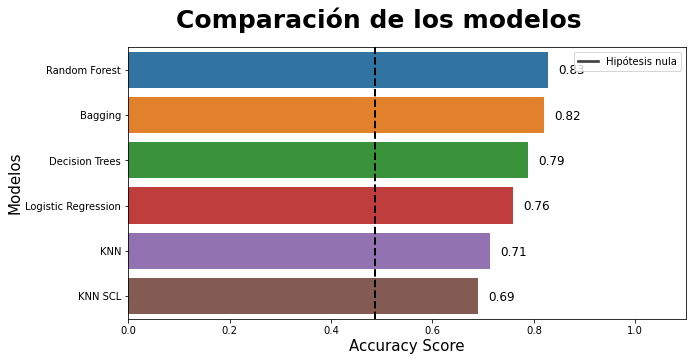

In [68]:
# Generamos una lista.
y_ticks=np.arange(len(listado_modelos))

#Generamos un df con la lista de algoritmos y la lista de puntajes de accuracy y ordenamos el valor según el puntaje de precisión.
df_accuracy=pd.DataFrame(list(zip(listado_modelos, accuracy_modelos)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = False)

#Imprimimos nuestra hipotesis nula.
print('Nuestra hipótesis nula es:',round(hipotesis_nula,2))

# Visualizamos con un gráfico.
plt.figure(figsize=(10,5))
ax = sns.barplot(x = df_accuracy['Accuracy_Score'], y=df_accuracy['Algorithm'], data=df_accuracy)

#ax=df_accuracy.plot.barh(legend=False, figsize=(10,5))
plt.axvline(x = hipotesis_nula, color = "black", label = "Hipotesis nula", linewidth=2, linestyle = 'dashed') # graficamos la linea

#incertamos los numeros en las barras.
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.5, str(round(i.get_width(),2)), fontsize=12)

plt.xlim(0,1.1)
plt.title('Comparación de los modelos', size=25, color='black',weight = 'bold',y=1.05, x=0.45)
plt.xlabel('Accuracy Score', size=15, labelpad=3)
plt.ylabel('Modelos', size=15, labelpad=3)
plt.yticks(y_ticks, df_accuracy['Algorithm'], rotation=0)
plt.legend(labels =['Hipótesis nula'], prop={'size': 10}, loc='best')
plt.show()

<h2> 2.8. Modelo de ensamble <div id='ensamble'>

<h7> Luego de haber realizado los modelos de Random Forest, Regresión Logística y KNN, vamos a combinarlos usando la herramienta de ensamble y ver si de esa forma podemos construir un modelo más robusto que nos de mayor accuracy sobre la predicción de la severidad de los accidentes del estado seleccionado.

In [69]:
#Creamos una funsión para construir el ensamble de los tres modelos seleccionados.
def predict_ensamble(X,model_1, model_2, model_3):
    y_pred_1 = model_1.predict(X)
    y_pred_2 = model_2.predict(X)
    y_pred_3 = model_3.predict(X)
    result_mode = mode([y_pred_1, y_pred_2, y_pred_3]).mode
    result = np.transpose(result_mode)    
    return result

El accuracy del modelo de ensamble es: 0.813


Text(0.5, 24.0, 'Severidad Predicha')

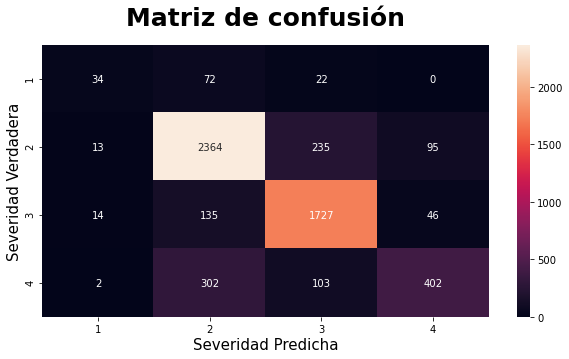

In [70]:
#Evaluamos la performance en test y buscamos el accuracy del ensable.
predict_cat_ensemble = predict_ensamble(X_test_scl, fit_1, fit_2, fit_3)
accuracy_ensemble = accuracy_score(y_test, predict_cat_ensemble)
print('El accuracy del modelo de ensamble es:', round(accuracy_ensemble,3))

#Realizamos una matríz de confusión.
predict_cat_ensemble.shape
conf_mat_ensemble = confusion_matrix(y_test, predict_cat_ensemble)

plt.figure(figsize=(10,5))
plt.title('Matriz de confusión', size=25, color='black',weight = 'bold',y=1.05)
sns.heatmap(confusion_matrix(y_test, predict_cat_ensemble), annot=True,fmt="g",xticklabels=[1,2,3,4],yticklabels=[1,2,3,4])
plt.ylabel('Severidad Verdadera', size=15, labelpad=3)
plt.xlabel('Severidad Predicha', size=15, labelpad=3)

<h7> En **conclusión**, si bien el **modelo de ensamble da un accuracy superior a los modelos de Regresión Logística y KNN** la performance es **ligeramente inferior** a los árboles de clasificación implementados con **Bagging y Random Forest**.

<h1> 3. PIPELINE <div id='pipeline'>

<h7> En primer lugar vamos a implementar un pipeline sencillo con el modelo KNN que combina un **Pipeline** + **Gridsearch**.

<h7> En los pasos del pipeline vamos a instruir al modelo que busue la mejor alternativa de estandarización y que corra el modelo knn.

In [71]:
pasos = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]
pipe_grid = Pipeline(pasos)

<h7> Para CrossValidation, vamos a intentar con 5 splits y activando la opción de shuffle.

In [72]:
folds=StratifiedKFold(n_splits=5,shuffle=True)

<h7> En la grilla de parámetros del modelo, seteamos para que lo instancie con un rango de vecinos entre 1 y 5 y que encuentre la mejor ponderación de la distancia eligiendo entre "uniforme" y "distancia".

In [73]:
param_grid = [{'scaler':[StandardScaler(), MinMaxScaler(),None],
               'knn__n_neighbors':range(1,6),'knn__weights':['uniform','distance']}]

In [74]:
grid = GridSearchCV(pipe_grid, param_grid, cv=folds)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__n_neighbors': range(1, 6),
                          'knn__weights': ['uniform', 'distance'],
                          'scaler': [StandardScaler(), MinMaxScaler(), None]}])

In [75]:
print('Score: ',grid.best_score_)
grid.best_estimator_

Score:  0.7230850543189083


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])

<h7> Luego de ejecutar el pipeline observamos que el mayor accuracy entre las opciones establecidas fue de 0.72 y dicho resultado se alcanzó sin estandarizar, con un número de 1 vecino y utilizando "distance" como ponderador de las distancias.

In [76]:
accuracy_score(grid.best_estimator_.predict(X_test),y_test)

0.7315846209126842

<h7> A continuación implementaremos un pipeline con el modelo de regresión logística que combine **Pipeline** + **Gridsearch** + **Preprocessing** con un **_Data Transformer_** customizado que seleccione las mejores features a utilizar por el modelo.

from sklearn.base import BaseEstimator, TransformerMixin<h7> Como primer paso, vamos a generar una **clase** que contenga al Data Transformer

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

In [78]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    
    def __init__(self,selected_features):
        self.selected_features=selected_features
    
    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

In [79]:
from sklearn.feature_selection import RFE

<h7> Luego definimos el valor máximo de features a conservar utilizando el **_wrapper method_** de **_Eliminación Recursiva de Fetures (RFE)_**

In [80]:
n_features_to_select=1
estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(estimator, n_features_to_select, step = 5)

rfe.fit(X, y)

scores = pd.DataFrame()
scores["Attribute Name"] = X.columns; scores["Ranking"] = rfe.ranking_; scores["Support"] = rfe.support_

C:\Users\User\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\User\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

In [81]:
scores= scores.sort_values('Ranking',ignore_index=True)

In [82]:
scores["Attribute Name"].loc[0:5]

0    Dec
1    Aug
2    Oct
3    Nov
4    Jul
5    Jan
Name: Attribute Name, dtype: object

In [83]:
cantidad_features= [5,10,15,20]
d={}
for i in cantidad_features:
    features= scores["Attribute Name"].loc[0:i].tolist()
    d["features_{0}".format(i)]=X[features].columns.values
d

{'features_5': array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan'], dtype=object),
 'features_10': array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan', 'Highway',
        'Street_&_Ave', 'Sep', 'Traffic_Signal', 'Feb'], dtype=object),
 'features_15': array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan', 'Highway',
        'Street_&_Ave', 'Sep', 'Traffic_Signal', 'Feb',
        'Sunrise_Sunset_Night', 'Jun', 'Distance(mi)', 'Sun', 'Stop'],
       dtype=object),
 'features_20': array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan', 'Highway',
        'Street_&_Ave', 'Sep', 'Traffic_Signal', 'Feb',
        'Sunrise_Sunset_Night', 'Jun', 'Distance(mi)', 'Sun', 'Stop',
        'Sat', 'May', 'Start_Lat', 'Crossing', 'Junction'], dtype=object)}

In [84]:
features_5= d.get("features_5")
features_10=d.get("features_10")
features_15=d.get("features_15")
features_20=d.get("features_20")

<h7> Creamos el objeto **_selector_** utilizando la clase de **_DataTransformer_** que definimos

In [85]:
selector=FeatureSelection(selected_features=X[features_5].columns.values)
selector

FeatureSelection(selected_features=array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan'], dtype=object))

In [86]:
selector_5=FeatureSelection(selected_features=X[features_5].columns.values)
selector_10=FeatureSelection(selected_features=X[features_10].columns.values)
selector_15=FeatureSelection(selected_features=X[features_15].columns.values)
selector_20=FeatureSelection(selected_features=X[features_20].columns.values)

In [87]:
pasos = [('feature_engineering',selector),
         ('preprocesamiento', StandardScaler()), 
         ('clasificador', LogisticRegression(solver='lbfgs'))]

pipe=Pipeline(pasos)

<h7> Creamos el objeto **_fold_** que contiene los pasos a seguir por el CrossValidation

In [88]:
folds=StratifiedKFold(n_splits=5,shuffle=True)

Definimos la grilla de hiperparámetros **_param_grid_** y ejecutamos el pipeline con el conjunto de entrenamiento

In [89]:
param_grid = [{'feature_engineering':[selector_5,selector_10,selector_15,selector_20,None],
               'preprocesamiento':[StandardScaler(), MinMaxScaler()],
               'clasificador__C':[0.01,0.1,1,10,100,1000]}]

grid=GridSearchCV(pipe, param_grid, cv=folds)

grid.fit(X_train,y_train)

C:\Users\User\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('feature_engineering',
                                        FeatureSelection(selected_features=array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan'], dtype=object))),
                                       ('preprocesamiento', StandardScaler()),
                                       ('clasificador', LogisticRegression())]),
             param_grid=[{'clasificador__C': [0.01, 0.1, 1, 10, 100, 100...
       'Sunrise_Sunset_Night', 'Jun', 'Distance(mi)', 'Sun', 'Stop'],
      dtype=object)),
                                                  FeatureSelection(selected_features=array(['Dec', 'Aug', 'Oct', 'Nov', 'Jul', 'Jan', 'Highway',
       'Street_&_Ave', 'Sep', 'Traffic_Signal', 'Feb',
       'Sunrise_Sunset_Night', 'Jun', 'Distance(mi)', 'Sun', 'Stop',
       'Sat', 'May', 'Start_Lat', 'Crossing', 'Junction'], dtype=object)),
                                             

In [90]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

Pipeline(steps=[('feature_engineering', None),
                ('preprocesamiento', StandardScaler()),
                ('clasificador', LogisticRegression(C=1))])
{'clasificador__C': 1, 'feature_engineering': None, 'preprocesamiento': StandardScaler()}
0.7535030500936267


In [91]:
y_pred = grid.best_estimator_.predict(X_test)

In [92]:
accuracy_score(grid.best_estimator_.predict(X_test),y_test)

0.7583542939274165

<h1> 4. PICKLE / FLASK <div id='pickle'>

<h7> Finalmente vamos a intentar serializar el modelo de regresión logística para poder hacer un deploy del modelo

In [120]:
import pickle
import shelve
import requests
from flask import  Flask, request, jsonify, render_template
import json


<h7> observamos si los archivos se crearon en la carpeta en donde estamos ejecutando la notebook

In [124]:
import os

[x for x in os.listdir() if 'pkl' in x]

[]

<h7> Serialización con pickle del modelo

In [125]:
with open(r'C:/Users/User/Documents/Mis_documentos/Digital_House/WS_Final/WS_Final_Grupo_5/WS_Integrador_Grupo5/lr_model.pkl', "wb") as f_lr_model:
    pickle.dump(lr, f_lr_model)

<h7> Serialización con pickle del dataframe

In [126]:
with open(r'C:/Users/User/Documents/Mis_documentos/Digital_House/WS_Final/WS_Final_Grupo_5/WS_Integrador_Grupo5/df.pkl', 'wb') as f_df:
    pickle.dump(df, f_df)